In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate
from classy import Class

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

## Best fitting with CLASS and scipy.optimize

In [2]:
home = os.getcwd()
print('Current working directory:', home)

Current working directory: /mnt/c/Users/darby/OneDrive/Desktop/cosmo_dep_feedback


In [44]:
# Fixed cosmological parameters
Ω_b = 0.049
h = 0.6711
n_s = 0.9624
ω = -1
M_ν = 0.0 #eV
Ω_k = 0

In [4]:
## Load in IllustrisTNG simulation parameters
lhc_TNG = np.loadtxt(home+'/latin_hypercube_params_IllustrisTNG.txt')

# Ω_m, σ_8, A_SN1, A_SN2, A_AGN1, A_AGN2
Ω_m, σ_8, A1, A2, A3, A4 = lhc_TNG[:,0], lhc_TNG[:,1], lhc_TNG[:,2], lhc_TNG[:,2], lhc_TNG[:,4], lhc_TNG[:,5]

In [10]:
## Load in data 
# redshift, z = 0.00
k = np.load(home+'/Pk/IllustrisTNG_k_m_z=0.00.npy')
Pk = np.load(home+'/Pk/IllustrisTNG_Pk_m_z=0.00.npy')
Pk0 = Pk[0]
# k.shape, Pk.shape, Pk[0].shape

k_cut, Pk0_cut = k[0:325], Pk0[0:325] # Cut off artifact at large wavenumber
k_cut.shape, Pk0_cut.shape

((325,), (325,))

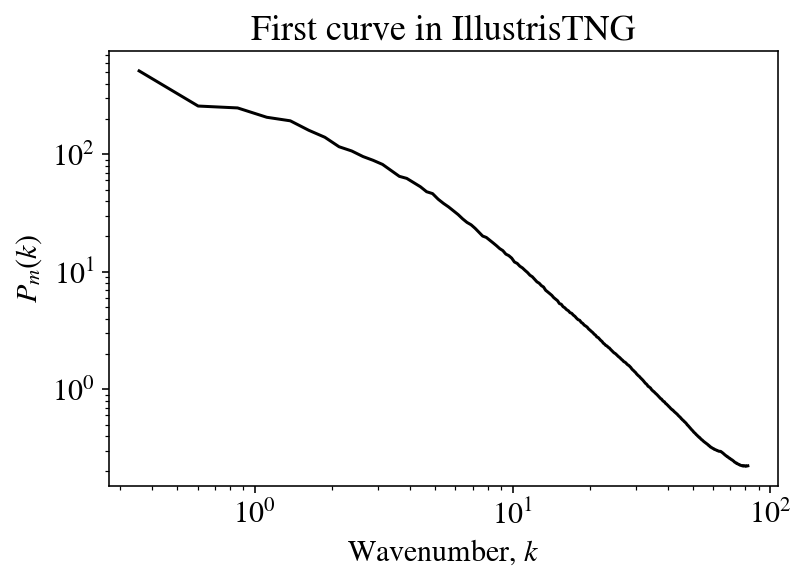

In [11]:
plt.figure()
plt.title('First curve in IllustrisTNG')
plt.loglog(k_cut, Pk0_cut, 'k')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

In [33]:
# Interpolating k values
# interp = scipy.interpolate.interp1d(k, Pk0)

# Curve fit model using CLASS
def class_model(x_data, eta, c):
    model = Class()
    model.set({'output':'mPk',
               'non_linear':'hmcode',
               'h': h,
               'n_s': n_s,
               'Omega_b': Ω_b,
               'Omega_k': Ω_k,
               'eta_0': eta,
               'c_min': c,
               'P_k_max_h/Mpc': 100,  # This value must agree with max value in logspace for k_model
               'lensing':'no',
               'z_pk':0 
              })
    model.compute()
    
    k_model = np.logspace(-1, 2, len(x_data))
    
    Pk_model = [] 
    h = model.h() 
    for k in k_model:
        Pk = model.pk(k*h, 0)*h**3
        Pk_model.append(Pk) 
    Pk_model = np.array(Pk_model)
    
    return Pk_model

In [34]:
guesses = np.array([0.89, 1.98])
opt, cov = scipy.optimize.curve_fit(class_model, k, Pk0, guesses) 
opt

array([3.99978965e+01, 7.24256628e-04])

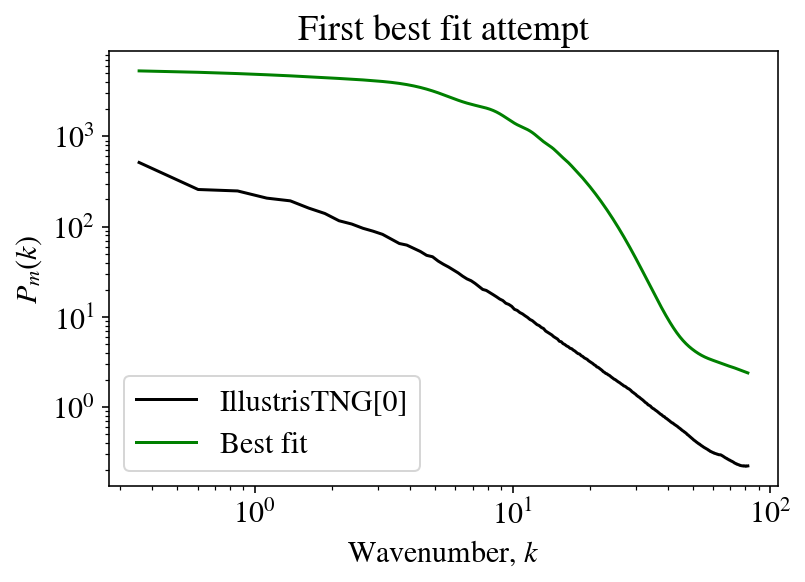

In [35]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k', label='IllustrisTNG[0]')
plt.loglog(k_cut, class_model(k_cut, *opt), 'g', label='Best fit')
plt.legend()
plt.title('First best fit attempt')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

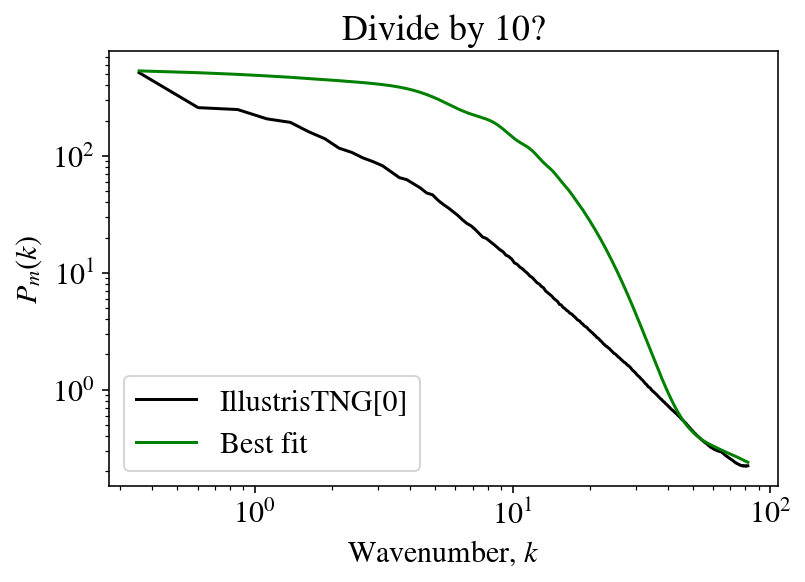

In [36]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k', label='IllustrisTNG[0]')
plt.loglog(k_cut, class_model(k_cut, *opt)/10, 'g', label='Best fit')
plt.legend()
plt.title('Divide by 10?')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

## Interpolation scratch work

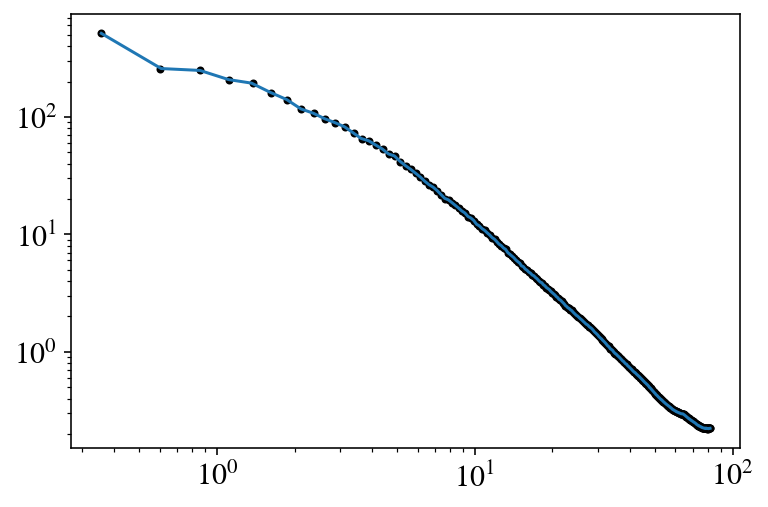

In [121]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k.')

xnew = np.linspace(min(k_cut), max(k_cut), len(k_cut))
f_lin = scipy.interpolate.interp1d(k_cut, Pk0_cut, fill_value='extrapolate', kind='linear')
plt.loglog(xnew, f_lin(xnew))

# plt.loglog(k_cut, Pk0_cut)
plt.show()

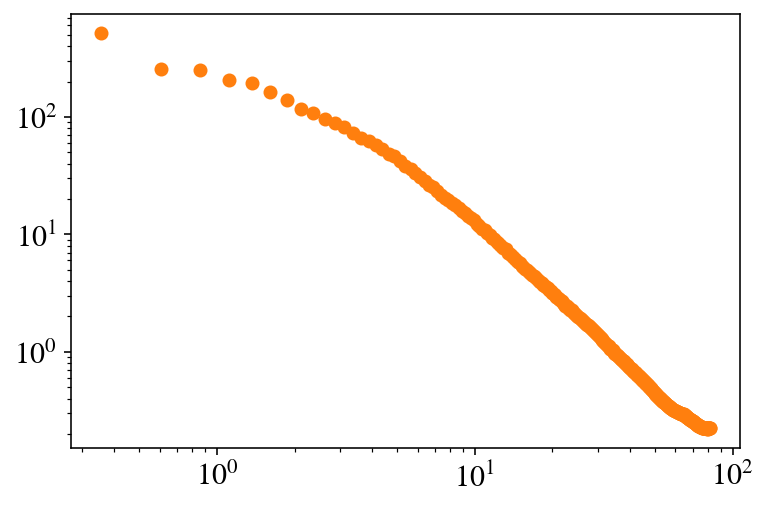

In [129]:
x = k_cut
y = Pk0_cut
# My x and y are the Pk and k data from IllustrisTNG
interp = scipy.interpolate.interp1d(x, y, fill_value="extrapolate") # Interpolator

xnew = np.linspace(min(x), max(x), len(k_cut))
ynew = interp(xnew)   # use interpolation function returned by `interp1d`
plt.loglog(x, y, '.') #
plt.loglog(xnew, ynew, 'o')
plt.show()
# orange is model --> CLASS Pk and k

### Trying CAMB for interest's sake

In [41]:
import camb

In [45]:
# Creating 'mead' model 
def baryon_model_mead(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=h*100, 
                           ombh2=Ω_b, 
                           omk=Ω_k, 
                           mnu=M_ν, 
                           ns=n_s,
                           w=ω,
                           redshifts=[0], 
                           kmax=max(xdata),
                           NonLinear='NonLinear_pk',
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_matter_power_spectrum(minkh=min(xdata), maxkh=max(xdata), npoints=len(xdata))
    return pk[0]

In [46]:
guesses_mead = np.array([3.13, 0.603, 7.8])
opt_mead, cov_mead = scipy.optimize.curve_fit(baryon_model_mead, k_cut, Pk0_cut, guesses_mead) 
print(opt_mead)

[-0.01540816  3.78763368  7.8       ]


/home/darbymccauley/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [47]:
# Creating 'mead2020_feedback' model 
def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=h*100, 
                           ombh2=Ω_b, 
                           omk=Ω_k, 
                           mnu=M_ν, 
                           ns=n_s,
                           w=ω,
                           redshifts=[0], 
                           kmax=max(xdata),
                           NonLinear='NonLinear_pk',
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_matter_power_spectrum(minkh=min(xdata), maxkh=max(xdata), npoints=len(xdata))
    return pk[0]

In [48]:
guesses_feedback = np.array([3.13, 0.603, 7.8])
opt_feedback, cov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, k_cut, Pk0_cut, guesses_feedback) 
print(opt_feedback)

[ 3.13        0.603      16.24542732]


In [49]:
# Creating the "pieced together" best fit parameters
opt_baryons = np.array([opt_mead[0], opt_mead[1], opt_feedback[2]])
print('Pieced together best fit params:', opt_baryons)

Pieced together best fit params: [-1.54081633e-02  3.78763368e+00  1.62454273e+01]


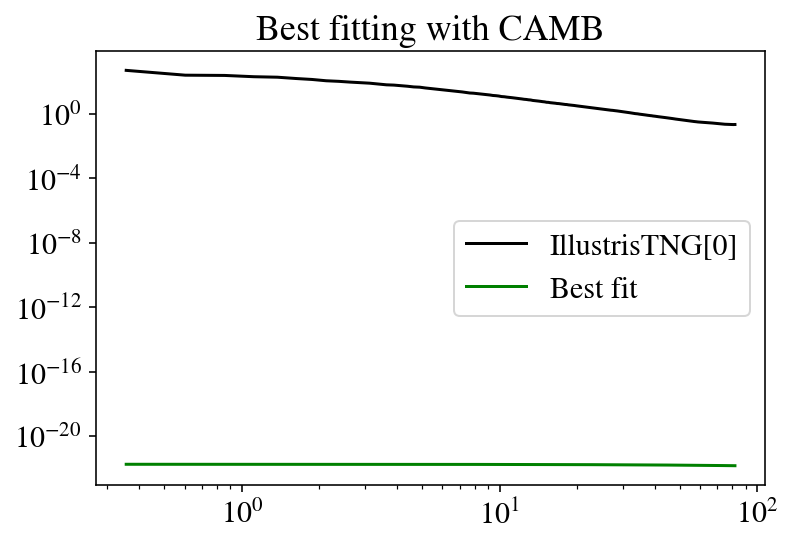

In [58]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k-', label='IllustrisTNG[0]')
plt.loglog(k_cut, baryon_model_feedback(k_cut, *opt_baryons), 'g-', label='Best fit')
plt.title('Best fitting with CAMB')
plt.legend()
plt.show()

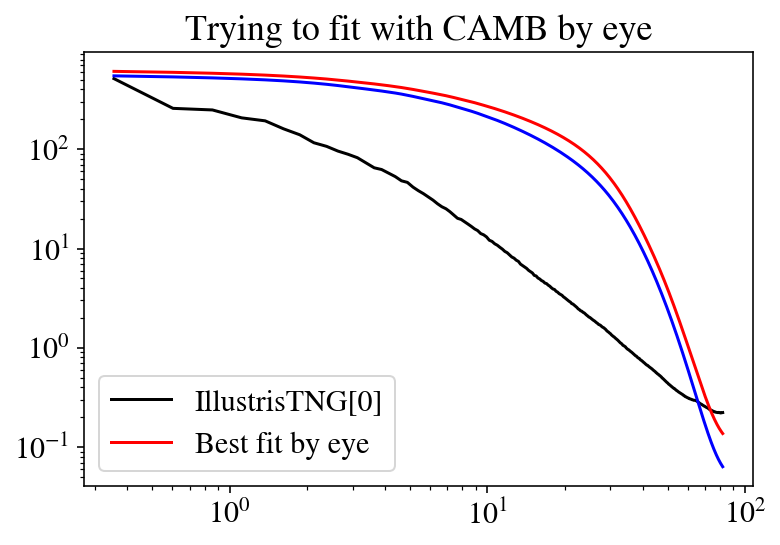

In [75]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k-', label='IllustrisTNG[0]')
plt.loglog(k_cut, baryon_model_feedback(k_cut, 3.13, 0.603, 7.8), 'r-', label='Best fit by eye')
plt.loglog(k_cut, baryon_model_feedback(k_cut, 3.13, 0.603, 10), 'b-')
plt.title('Trying to fit with CAMB by eye')
plt.legend()
plt.show()

## Hard to even fit by eye. A and eta do virtually nothing. All dependency seems to be in AGN.